In [13]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [14]:
resolution = 100
nfreq = 100

fcen = 1.75
df = 3.3

cell_size = mp.Vector3(30, 2, 0)

In [15]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000007
Iteration   1, error: 0.000015
Iteration   2, error: 0.000022
Iteration   3, error: 0.000018
Iteration   4, error: 0.000098
Iteration   5, error: 0.000285
Iteration   6, error: 0.000016
Iteration   7, error: 0.000011
Iteration   8, error: 0.000005
Iteration   9, error: 0.000011
Iteration  10, error: 0.000015
Iteration  11, error: 0.000013
Iteration  12, error: 0.000006
Iteration  13, error: 0.000005
Iteration  14, error: 0.000036
Iteration  15, error: 0.000014
Iteration  16, error: 0.000008
Iteration  17, error: 0.000021
Iteration  18, error: 0.000010
Iteration  19, error: 0.000206
Iteration  20, error: 0.000013
Iteration  21, error: 0.000006
Iteration  22, error: 0.000008
Iteration  23, error: 0.000016
Iteration  24, error: 0.000521
Iteration  25, error: 0.000026
Iteration  26, error: 0.000004
Iteration  27, error: 0.000014
Iteration  28, error: 0.000020
Iteration  29, error: 0.000010
Optimal error: 0.000004
Iteration   0, error: 71292.592314
Iteration  

In [16]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [17]:
pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

In [18]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [19]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=Cathode_center,
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=Alq3_center,
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=aNDP_center,
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=ITO_center,
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=Cover_center,
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=Glass_center,
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [20]:
source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [21]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


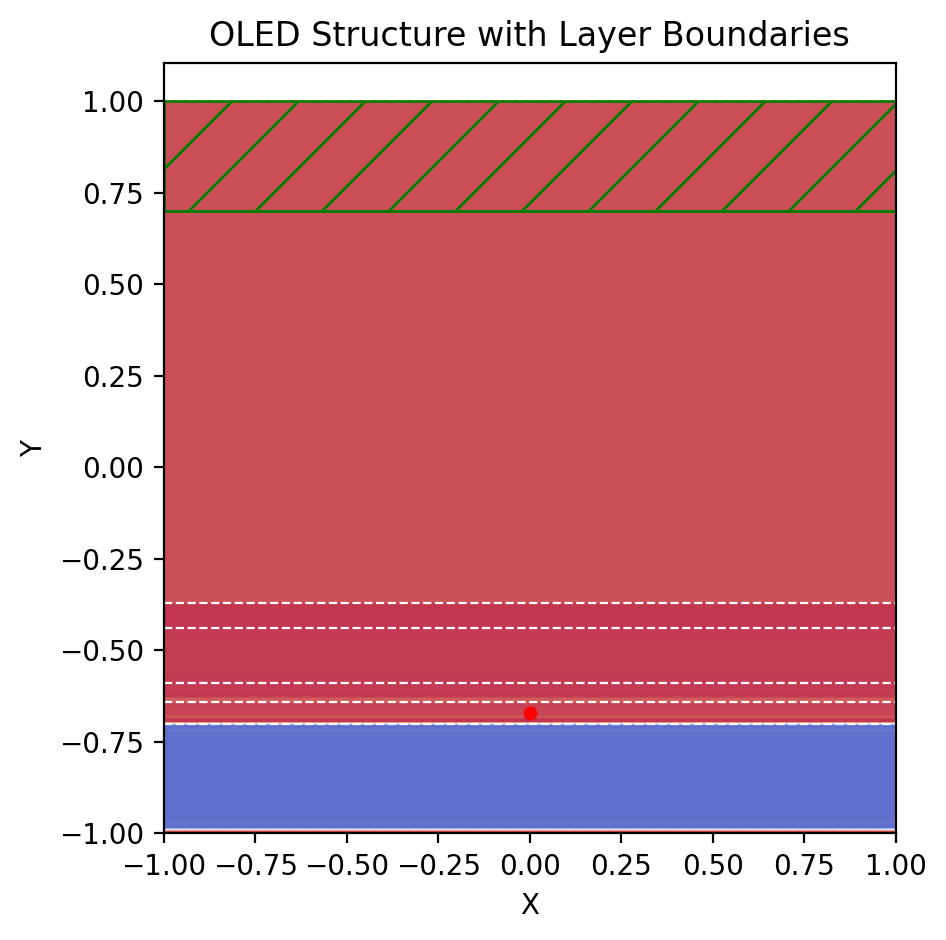

In [24]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()